# Imbalanced Weighted Binary Classification

In [1]:
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

1.13.1


## Get data

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [4]:
FEATURE_NAMES = list(df.columns)
NUMERIC_FEATURE_NAMES = "LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6".split(',')
CATEGORICAL_FEATURE_NAMES = "SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6".split(',')
LABEL_NAME = FEATURE_NAMES[-1]

In [5]:
train_rows = int(len(df) * 0.9)
eval_rows = len(df) - train_rows
print("train_rows = {} & eval_rows = {}".format(train_rows, eval_rows))

train_rows = 27000 & eval_rows = 3000


## Create model

In [6]:
def train_input_fn(df, batch_size = 128):
    #1. Convert dataframe into correct (features,label) format for Estimator API
    dataset = tf.data.Dataset.from_tensor_slices(tensors = (dict(df[FEATURE_NAMES]), df[LABEL_NAME]))
    
    # Note:
    # If we returned now, the Dataset would iterate over the data once  
    # in a fixed order, and only produce a single element at a time.
    
    #2. Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(buffer_size = 1000).repeat(count = None).batch(batch_size = batch_size)
   
    return dataset

def eval_input_fn(df, batch_size = 128):
    #1. Convert dataframe into correct (features,label) format for Estimator API
    dataset = tf.data.Dataset.from_tensor_slices(tensors = (dict(df[FEATURE_NAMES]), df[LABEL_NAME]))
    
    #2.Batch the examples.
    dataset = dataset.batch(batch_size = batch_size)
   
    return dataset

In [7]:
def create_feature_columns():
    numeric_columns = [tf.feature_column.numeric_column(key = key) for key in NUMERIC_FEATURE_NAMES]
    categorical_columns = [tf.feature_column.indicator_column(
        categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(key = key, vocabulary_list = list(df[key].unique()))) for key in CATEGORICAL_FEATURE_NAMES]
    
    feature_columns = numeric_columns + categorical_columns
    
    return feature_columns

In [8]:
# This function updates the count of records used
def update_count(count_a, count_b):
    count_ab = count_a + count_b
    return count_ab

# This function updates the mahalanobis distance variables when the current_batch_size equals 1
def singleton_batch_variable_updating(X, count_variable, mean_variable, variance_variable):
    # This function updates the mean vector incrementally
    def update_mean_incremental(count_a, mean_a, value_b):
        mean_ab = (mean_a * tf.cast(x = count_a, dtype = tf.float64) + tf.squeeze(input = value_b, axis = 0)) / tf.cast(x = count_a + 1, dtype = tf.float64)
        return mean_ab

    # This function updates the variance matrix incrementally
    def update_variance_incremental(count_a, mean_a, var_a, value_b, mean_ab, sample_variance):
        if sample_variance == True:
            var_ab = (var_a * tf.cast(x = count_a - 1, dtype = tf.float64) + (tf.squeeze(input = value_b, axis = 0) - mean_a) * (tf.squeeze(input = value_b, axis = 0) - mean_ab)) \
                / tf.cast(x = count_a, dtype = tf.float64)
        else:
            var_ab = (var_a * tf.cast(x = count_a, dtype = tf.float64) + (tf.squeeze(input = value_b, axis = 0) - mean_a) * (tf.squeeze(input = value_b, axis = 0) - mean_ab)) \
                / tf.cast(x = count_a + 1, dtype = tf.float64)
        return var_ab

    # Calculate new combined mean to use for incremental variance matrix calculation
    mean_ab = update_mean_incremental(
        count_a = count_variable, 
        mean_a = mean_variable, 
        value_b = X)

    # Update running variables from single example
    label_prob_count_tensor = update_count(
        count_a = count_variable, 
        count_b = 1)

    label_prob_mean_tensor = mean_ab

    label_prob_variance_tensor = update_variance_incremental(
        count_a = count_variable, 
        mean_a = mean_variable, 
        var_a = variance_variable, 
        value_b = X, 
        mean_ab = mean_ab, 
        sample_variance = True)

    # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
    with tf.control_dependencies(control_inputs = [tf.assign(ref = variance_variable, value = label_prob_variance_tensor)]):
        with tf.control_dependencies(control_inputs = [tf.assign(ref = mean_variable, value = label_prob_mean_tensor)]):
            with tf.control_dependencies(control_inputs = [tf.assign(ref = count_variable, value = label_prob_count_tensor)]):
                return tf.identity(input = variance_variable), tf.identity(input = mean_variable), tf.identity(input = count_variable)

# This function updates the mahalanobis distance variables when the current_batch_size does NOT equal 1
def non_singleton_batch_variable_updating(current_batch_size, X, count_variable, mean_variable, variance_variable):
    # This function updates the mean vector using a batch of data
    def update_mean_batch(count_a, mean_a, count_b, mean_b):
        mean_ab = (mean_a * tf.cast(x = count_a, dtype = tf.float64) + mean_b * tf.cast(x = count_b, dtype = tf.float64)) \
            / tf.cast(x = count_a + count_b, dtype = tf.float64)
        return mean_ab

    # This function updates the variance matrix using a batch of data
    def update_variance_batch(count_a, mean_a, var_a, count_b, mean_b, var_b, sample_variance):
        mean_diff = mean_a - mean_b

        if sample_variance == True:
            var_ab = (var_a * tf.cast(x = count_a - 1, dtype = tf.float64) + var_b * tf.cast(x = count_b - 1, dtype = tf.float64) \
                      + tf.square(x = mean_diff) * tf.cast(x = count_a * count_b, dtype = tf.float64) \
                      / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b - 1, dtype = tf.float64)
        else:
            var_ab = (var_a * tf.cast(x = count_a, dtype = tf.float64) + var_b * tf.cast(x = count_b, dtype = tf.float64) \
                      + tf.square(x = mean_diff) * tf.cast(x = count_a * count_b, dtype = tf.float64) \
                      / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b, dtype = tf.float64)
        return var_ab                    

    # Find statistics of batch
    X_mean = tf.reduce_mean(input_tensor = X)

    X_centered = X - X_mean

    X_variance = tf.reduce_sum(input_tensor = tf.square(x = X_centered)) / tf.cast(x = current_batch_size - 1, dtype = tf.float64)

    # Update running variables from batch statistics
    label_prob_count_tensor = update_count(
        count_a = count_variable, 
        count_b = current_batch_size)

    label_prob_mean_tensor = update_mean_batch(
        count_a = count_variable, 
        mean_a = mean_variable, 
        count_b = current_batch_size, 
        mean_b = X_mean)

    label_prob_variance_tensor = update_variance_batch(
        count_a = count_variable, 
        mean_a = mean_variable, 
        var_a = variance_variable, 
        count_b = current_batch_size, 
        mean_b = X_mean, 
        var_b = X_variance, 
        sample_variance = True)

    # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
    with tf.control_dependencies(control_inputs = [tf.assign(ref = variance_variable, value = label_prob_variance_tensor)]):
        with tf.control_dependencies(control_inputs = [tf.assign(ref = mean_variable, value = label_prob_mean_tensor)]):
            with tf.control_dependencies(control_inputs = [tf.assign(ref = count_variable, value = label_prob_count_tensor)]):
                return tf.identity(input = variance_variable), tf.identity(input = mean_variable), tf.identity(input = count_variable)

In [9]:
def model_fn(features, labels, mode, params):
#     print("\nfeatures = \n{}".format(features))
#     print("labels = \n{}".format(labels))
#     print("mode = \n{}".format(mode))
#     print("params = \n{}".format(params))
    
    input_layer = tf.cast(x = tf.feature_column.input_layer(features = features, feature_columns = create_feature_columns()), dtype = tf.float64)
    logits = tf.squeeze(input = tf.layers.dense(inputs = input_layer, units = 1, activation = None), axis = -1)
    probabilities = tf.nn.sigmoid(x = logits) # shape = (current_batch_size, NCLASSES)
    class_ids = tf.where(condition = probabilities < 0.5, 
                         x = tf.zeros_like(tensor = probabilities, dtype = tf.float64), 
                         y = tf.ones_like(tensor = probabilities, dtype = tf.float64)) # shape = (current_batch_size,)
    
    label_prob_count_variable = tf.get_variable(
        name = "label_prob_count_variable",
        dtype = tf.int64,
        initializer = tf.zeros(shape = [], dtype = tf.int64),
        trainable = False)

    label_prob_mean_variable = tf.get_variable(
        name = "label_prob_mean_variable",
        dtype = tf.float64,
        initializer = tf.zeros(shape = [], dtype = tf.float64),
        trainable = False)

    label_prob_variance_variable = tf.get_variable(
        name = "label_prob_variance_variable",
        dtype = tf.float64,
        initializer = tf.zeros(shape = [], dtype = tf.float64),
        trainable = False)
    
    pred_prob_count_variable = tf.get_variable(
        name = "pred_prob_count_variable",
        dtype = tf.int64,
        initializer = tf.zeros(shape = [], dtype = tf.int64),
        trainable = False)

    pred_prob_mean_variable = tf.get_variable(
        name = "pred_prob_mean_variable",
        dtype = tf.float64,
        initializer = tf.zeros(shape = [], dtype = tf.float64),
        trainable = False)

    pred_prob_variance_variable = tf.get_variable(
        name = "pred_prob_variance_variable",
        dtype = tf.float64,
        initializer = tf.zeros(shape = [], dtype = tf.float64),
        trainable = False)
    
    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        labels = tf.cast(x = labels, dtype = tf.float64)
        
        loss = tf.reduce_mean(input_tensor = tf.nn.weighted_cross_entropy_with_logits(targets = labels, logits = logits, pos_weight = params["pos_weight"]))
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            train_op = tf.contrib.layers.optimize_loss(
                loss = loss, 
                global_step = tf.train.get_global_step(),
                learning_rate = params["learning_rate"], 
                optimizer = "Adam")
            eval_metric_ops = None
        else:
            # Check if batch is a singleton or not, very important for variance math
            current_batch_size = tf.shape(input = labels, out_type = tf.int64)[0]
            singleton_condition = tf.equal(x = current_batch_size, y = 1) # shape = ()

            # Find statistics of label probabilitiy distribution
            label_variance_update_op, label_mean_update_op, label_count_update_op = \
                tf.cond(
                    pred = singleton_condition, 
                    true_fn = lambda: singleton_batch_variable_updating(labels, label_prob_count_variable, label_prob_mean_variable, label_prob_variance_variable), 
                    false_fn = lambda: non_singleton_batch_variable_updating(current_batch_size, labels, label_prob_count_variable, label_prob_mean_variable, label_prob_variance_variable))
            
            # Find statistics of prediction probabilitiy distribution
            pred_variance_update_op, pred_mean_update_op, pred_count_update_op = \
                tf.cond(
                    pred = singleton_condition, 
                    true_fn = lambda: singleton_batch_variable_updating(probabilities, pred_prob_count_variable, pred_prob_mean_variable, pred_prob_variance_variable), 
                    false_fn = lambda: non_singleton_batch_variable_updating(current_batch_size, probabilities, pred_prob_count_variable, pred_prob_mean_variable, pred_prob_variance_variable))
            
            # Find difference between means of label and prediction probability distributions
            prob_mean_abs_diff_var = tf.abs(x = label_prob_mean_variable - pred_prob_mean_variable)
            prob_mean_abs_diff_update_op = tf.abs(x = label_mean_update_op - pred_mean_update_op)
            
            # Find difference between variances of label and prediction probability distributions
            prob_variance_abs_diff_var = tf.abs(x = label_prob_variance_variable - pred_prob_variance_variable)
            prob_variance_abs_diff_update_op = tf.abs(x = label_variance_update_op - pred_variance_update_op)
            
            # Create objective function hyperparameter tuning metric of a weighted sum of the differences of the mean and variance between labels and predictions
            prob_metric_obj_fn_var = prob_mean_abs_diff_var * 0.8 + prob_variance_abs_diff_var * 0.2
            prob_metric_obj_fn_update_op = prob_mean_abs_diff_update_op * 0.8 + prob_variance_abs_diff_update_op * 0.2
            
            train_op = None
            eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels = labels, predictions = class_ids),
                               "true_positives_at_thresholds": tf.metrics.true_positives_at_thresholds(labels = labels, predictions = probabilities, thresholds = list(np.arange(0.0, 1.005, 0.005))), 
                               "false_negatives_at_thresholds": tf.metrics.false_negatives_at_thresholds(labels = labels, predictions = probabilities, thresholds = list(np.arange(0.0, 1.005, 0.005))),
                               "false_positives_at_thresholds": tf.metrics.false_positives_at_thresholds(labels = labels, predictions = probabilities, thresholds = list(np.arange(0.0, 1.005, 0.005))), 
                               "true_negatives_at_thresholds": tf.metrics.true_negatives_at_thresholds(labels = labels, predictions = probabilities, thresholds = list(np.arange(0.0, 1.005, 0.005))),
                               "precision_at_thresholds": tf.metrics.precision_at_thresholds(labels = labels, predictions = probabilities, thresholds = list(np.arange(0.0, 1.005, 0.005))), 
                               "recall_at_thresholds": tf.metrics.recall_at_thresholds(labels = labels, predictions = probabilities, thresholds = list(np.arange(0.0, 1.005, 0.005))),
                               "label_prob_mean": (label_prob_mean_variable, label_mean_update_op),
                               "label_prob_variance": (label_prob_variance_variable, label_variance_update_op),
                               "pred_prob_mean": (pred_prob_mean_variable, pred_mean_update_op),
                               "pred_prob_variance": (pred_prob_variance_variable, pred_variance_update_op),
                               "prob_mean_abs_diff": (prob_mean_abs_diff_var, prob_mean_abs_diff_update_op),
                               "prob_variance_abs_diff": (prob_variance_abs_diff_var, prob_variance_abs_diff_update_op),
                               "prob_metric_obj_fn": (prob_metric_obj_fn_var, prob_metric_obj_fn_update_op),
                               "auc_roc": tf.metrics.auc(labels = labels, predictions = probabilities, curve = "ROC", summation_method = "careful_interpolation"),
                               "auc_pr": tf.metrics.auc(labels = labels, predictions = probabilities, curve = "PR", summation_method = "careful_interpolation")}
    else:
        loss = None
        train_op = None
        eval_metric_ops = None
 
    return tf.estimator.EstimatorSpec(
                mode = mode,
                predictions = {"probabilities": probabilities, "class_ids": class_ids},
                loss = loss,
                train_op = train_op,
                eval_metric_ops = eval_metric_ops,
                export_outputs = {"classes": tf.estimator.export.PredictOutput({"probabilities": probabilities, "class_ids": class_ids})})

In [10]:
def serving_input_fn():
    numeric_feature_placeholders = {key: tf.placeholder(dtype = tf.float64, shape = [None]) for key in NUMERIC_FEATURE_NAMES}
    categorical_feature_placeholders = {key: tf.placeholder(dtype = tf.int64, shape = [None]) for key in CATEGORICAL_FEATURE_NAMES}
    
    feature_placeholders = {**numeric_feature_placeholders, **categorical_feature_placeholders}
    
    features = feature_placeholders
    
    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = feature_placeholders)

In [11]:
def train_and_evaluate(output_dir, hparams):
    tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
    EVAL_INTERVAL = 60

    estimator = tf.estimator.Estimator(
        model_fn = model_fn,
        params = hparams,
        config = tf.estimator.RunConfig(
            save_checkpoints_secs = EVAL_INTERVAL, 
            tf_random_seed = 1),
        model_dir = output_dir)

    train_spec = tf.estimator.TrainSpec(
        input_fn = lambda: train_input_fn(df = df[:train_rows], batch_size = hparams["train_batch_size"]),
        max_steps = hparams["train_steps"])

    exporter = tf.estimator.LatestExporter("exporter", serving_input_fn)

    eval_spec = tf.estimator.EvalSpec(
        input_fn = lambda: eval_input_fn(df = df[train_rows:], batch_size = hparams["eval_batch_size"]),
        steps = None,
        exporters = exporter,
        throttle_secs = EVAL_INTERVAL)
    
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    
    return estimator

In [12]:
hparams = {}
hparams["train_batch_size"] = 128
hparams["eval_batch_size"] = 128
hparams["learning_rate"] = 0.01
hparams["train_steps"] = 1000

## Train unweighted loss model

In [13]:
tf.logging.set_verbosity(v = tf.logging.INFO)
UNWEIGHTED_MODEL_DIR = "unweighted_trained"
hparams["pos_weight"] = 1.0
shutil.rmtree(path = UNWEIGHTED_MODEL_DIR, ignore_errors = True) # start fresh each time
unweighted_estimator = train_and_evaluate(UNWEIGHTED_MODEL_DIR, hparams)

INFO:tensorflow:Using config: {'_evaluation_master': '', '_task_type': 'worker', '_train_distribute': None, '_task_id': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f56b5fa0ba8>, '_service': None, '_experimental_distribute': None, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 60, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_device_fn': None, '_num_ps_replicas': 0, '_tf_random_seed': 1, '_save_summary_steps': 100, '_eval_distribute': None, '_is_chief': True, '_protocol': None, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'unweighted_trained', '_log_step_count_steps': 100}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evalu

## Now train weighted loss model

In [14]:
negative_positive_ratio = 1.0 / df[LABEL_NAME].mean()
negative_positive_ratio

4.520795660036166

In [15]:
tf.logging.set_verbosity(v = tf.logging.INFO)
WEIGHTED_MODEL_DIR = "weighted_trained"
hparams["pos_weight"] = negative_positive_ratio
shutil.rmtree(path = WEIGHTED_MODEL_DIR, ignore_errors = True) # start fresh each time
weighted_estimator = train_and_evaluate(WEIGHTED_MODEL_DIR, hparams)

INFO:tensorflow:Using config: {'_evaluation_master': '', '_task_type': 'worker', '_train_distribute': None, '_task_id': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f56ac1b6c88>, '_service': None, '_experimental_distribute': None, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 60, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_device_fn': None, '_num_ps_replicas': 0, '_tf_random_seed': 1, '_save_summary_steps': 100, '_eval_distribute': None, '_is_chief': True, '_protocol': None, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'weighted_trained', '_log_step_count_steps': 100}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluat

## Grid search

In [16]:
metrics_list = []
tf.logging.set_verbosity(v = tf.logging.ERROR)
for pos_weight in list(np.arange(0.1, 10.1, 0.1)):
    hparams["pos_weight"] = pos_weight
    UNWEIGHTED_MODEL_DIR = "unweighted_trained"
    shutil.rmtree(path = UNWEIGHTED_MODEL_DIR, ignore_errors = True) # start fresh each time
    weighted_estimator = tf.estimator.Estimator(
        model_fn = model_fn,
        params = hparams,
        config = tf.estimator.RunConfig(save_checkpoints_secs = 600, tf_random_seed = 1),
        model_dir = UNWEIGHTED_MODEL_DIR)
    weighted_estimator.train(input_fn = lambda: train_input_fn(df = df[:train_rows], batch_size = 128), steps = 1000)
    metrics = weighted_estimator.evaluate(input_fn = lambda: eval_input_fn(df = df[train_rows:], batch_size = 128))
    metrics_list.append(metrics)
    print("pos_weight = {}, metrics['accuracy'] = {}, metrics['auc_roc'] = {}, metrics['auc_pr'] = {}".format(pos_weight, metrics["accuracy"], metrics["auc_roc"], metrics["auc_pr"]))

pos_weight = 0.1, metrics['accuracy'] = 0.7789999842643738, metrics['auc_roc'] = 0.5, metrics['auc_pr'] = 0.22099998593330383
pos_weight = 0.2, metrics['accuracy'] = 0.7793333530426025, metrics['auc_roc'] = 0.500754177570343, metrics['auc_pr'] = 0.22399283945560455
pos_weight = 0.30000000000000004, metrics['accuracy'] = 0.778333306312561, metrics['auc_roc'] = 0.5006518959999084, metrics['auc_pr'] = 0.22241756319999695
pos_weight = 0.4, metrics['accuracy'] = 0.7766666412353516, metrics['auc_roc'] = 0.5001197457313538, metrics['auc_pr'] = 0.2209927886724472
pos_weight = 0.5, metrics['accuracy'] = 0.6539999842643738, metrics['auc_roc'] = 0.5160065293312073, metrics['auc_pr'] = 0.231878399848938
pos_weight = 0.6, metrics['accuracy'] = 0.7806666493415833, metrics['auc_roc'] = 0.5124346017837524, metrics['auc_pr'] = 0.24458304047584534
pos_weight = 0.7000000000000001, metrics['accuracy'] = 0.6380000114440918, metrics['auc_roc'] = 0.5748313665390015, metrics['auc_pr'] = 0.2685682773590088
pos

## Plot results

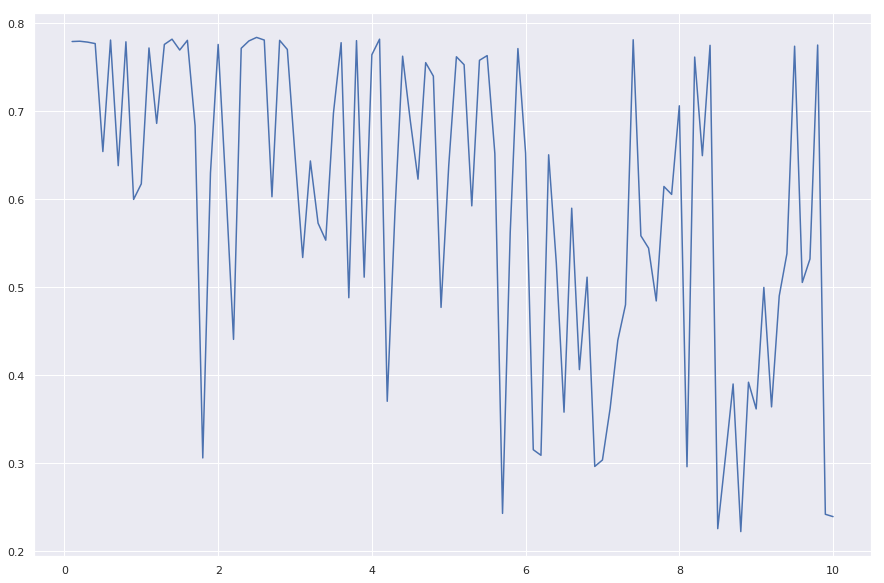

In [17]:
import seaborn as sns
sns.set(rc = {"figure.figsize": (15,10)})
sns.lineplot(x = "pos_weight", y = "accuracy", data = {"pos_weight": list(np.arange(0.1, 10.1, 0.1)), "accuracy": [metric["accuracy"] for metric in metrics_list]})

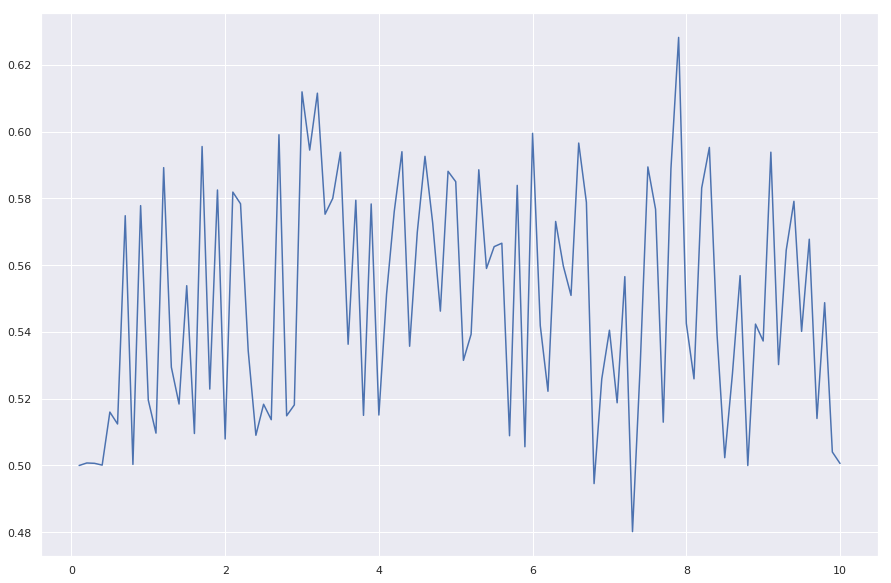

In [18]:
sns.lineplot(x = "pos_weight", y = "auc_roc", data = {"pos_weight": list(np.arange(0.1, 10.1, 0.1)), "auc_roc": [metric["auc_roc"] for metric in metrics_list]})

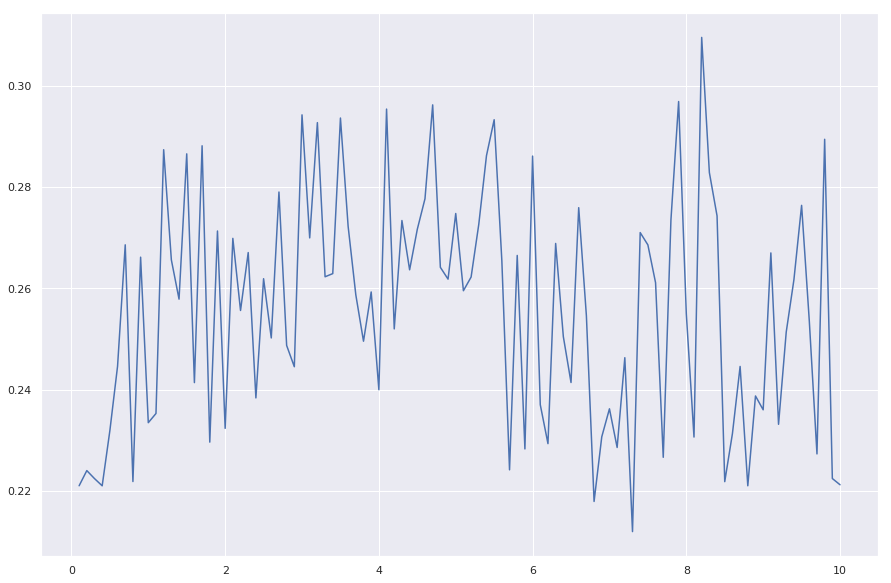

In [19]:
sns.lineplot(x = "pos_weight", y = "auc_pr", data = {"pos_weight": list(np.arange(0.1, 10.1, 0.1)), "auc_pr": [metric["auc_pr"] for metric in metrics_list]})

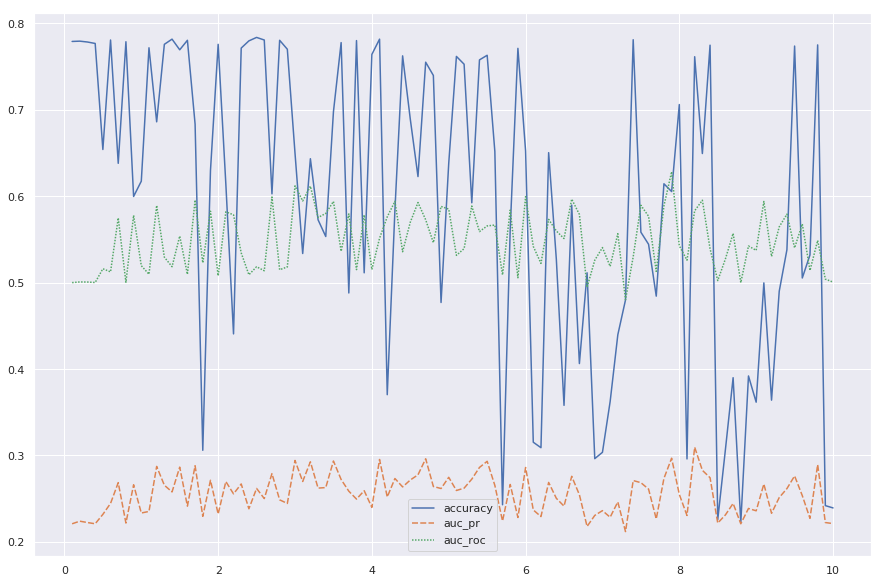

In [20]:
sns.lineplot(data = pd.DataFrame(data = {"accuracy": [metric["accuracy"] for metric in metrics_list],
                                         "auc_roc": [metric["auc_roc"] for metric in metrics_list],
                                         "auc_pr": [metric["auc_pr"] for metric in metrics_list]},
                                 index = list(np.arange(0.1, 10.1, 0.1))))

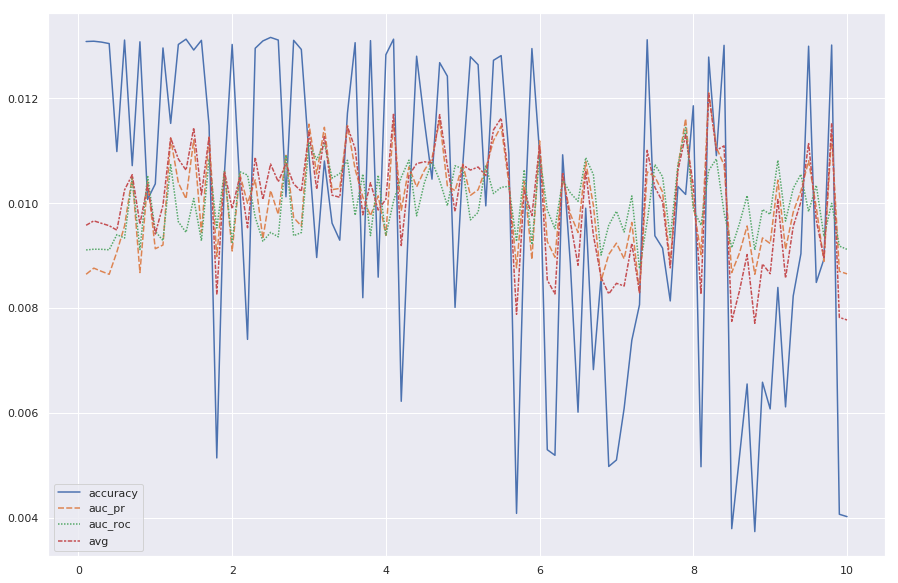

In [21]:
accuracy_arr = np.array([metric["accuracy"] for metric in metrics_list])
accuracy_arr /= np.sum(accuracy_arr)

auc_roc_arr = np.array([metric["auc_roc"] for metric in metrics_list])
auc_roc_arr /= np.sum(auc_roc_arr)

auc_pr_arr = np.array([metric["auc_pr"] for metric in metrics_list])
auc_pr_arr /= np.sum(auc_pr_arr)

sns.lineplot(data = pd.DataFrame(data = {"accuracy": accuracy_arr,
                                         "auc_roc": auc_roc_arr,
                                         "auc_pr": auc_pr_arr,
                                         "avg": (accuracy_arr * 0.2 + auc_roc_arr * 0.1 + auc_pr_arr * 0.7)}, 
                                 index = list(np.arange(0.1, 10.1, 0.1))))

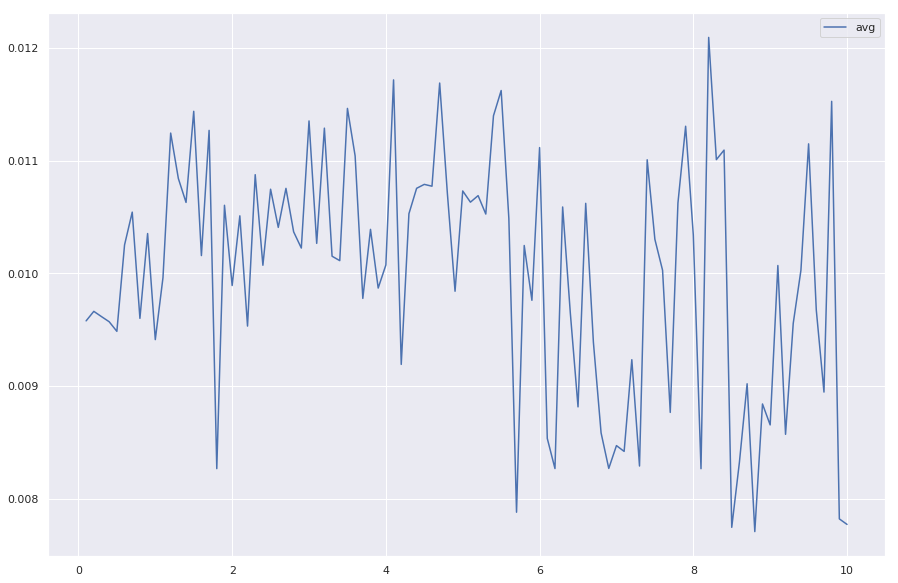

In [22]:
sns.lineplot(data = pd.DataFrame(data = {"avg": (accuracy_arr * 0.2 + auc_roc_arr * 0.1 + auc_pr_arr * 0.7)}, 
                                 index = list(np.arange(0.1, 10.1, 0.1))))

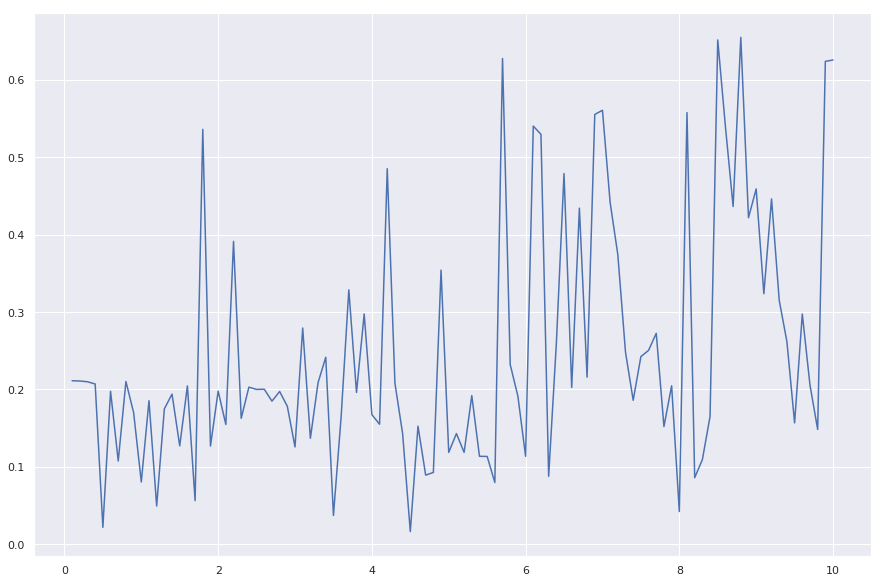

In [23]:
sns.lineplot(x = "pos_weight", y = "prob_metric_obj_fn", data = {"pos_weight": list(np.arange(0.1, 10.1, 0.1)), "prob_metric_obj_fn": [metric["prob_metric_obj_fn"] for metric in metrics_list]})